# Using logistic Regression on Toydata to get a high AMS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import linear_model as linMod

Data shall have the form of $[w,y,x_1,x_2]$ where

$w$ is a weight in the intervall $[0,1)$       
$y$ is the label "0" for "background" or "1" for "signal"       
$x_n$ are randomly generated features with respect to the label

In [2]:
def generateFeature(label, mu_s, mu_b, sigma_s=5, sigma_b=5):
    if label is 1:
        mu = mu_s
        sigma = sigma_s
    else:
        mu = mu_b
        sigma = sigma_b
    return np.random.normal(mu,sigma)

Approximate Median Significance (AMS) defined as:

$$AMS = \sqrt{2 { (s + b + b_r) log[1 + (s/(b+b_{reg}))] - s}}$$     
        
where $b_{reg} = 10$ is a regulization term (set by the contest),      
$b = \sum_{i=1}^{n} w_i, y_i=0$ is sum of weighted background (incorrectly classified as signal),           
$s = \sum_{i=1}^{n} w_i, y_i=1$ is sum of weighted signals (correctly classified as signal),           
$log$ is natural logarithm

In [3]:
def calcAMS(s,b):
    
    br = 10.0
    radicand = 2 *( (s+b+br) * math.log (1.0 + s/(b+br)) -s)
    if radicand < 0:
        print('radicand is negative. Exiting')
        exit()
    else:
        return math.sqrt(radicand)

In [4]:
def calcWeightSums(weights,preds,labels):
    s = 0
    b = 0
    for j in list(range(0,len(preds))):
        pred = preds[j]
        label = labels[j]
        weight = weights[j]
        if pred > 0.:
            if label > 0.:
                s += weight
            else:
                b += weight
    return s,b

actually generate data

In [5]:
n = 100000 #toydata shall have n vectors with 5 dimensions
s_prob = 0.05 #probability for signal-label
weights = np.random.rand(n) #random values will be used as weights for evaluation later
labels = np.zeros(n)
x_1 = np.zeros(n)
x_2 = np.zeros(n)

for i in range(0,n):
    if weights[i] <= s_prob:
        label = 1
    else:
        label = 0
    labels[i] = label
    x_1[i]=generateFeature(label,mu_s=5,mu_b=20)
    x_2[i]=generateFeature(label,mu_s=5,mu_b=25)

visualize

Populating the interactive namespace from numpy and matplotlib


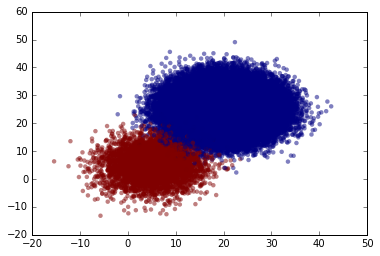

In [29]:
%pylab inline
plt.scatter(x_1, x_2, edgecolor="", c=labels, alpha=0.5)

In [7]:
def splitList(xList,n):
    aList = xList[:n]
    bList = xList[n:]
    return aList,bList

split toydata into training- and testset for the classifier

In [8]:
n_train = int(n/10)

train_x_1,test_x_1 = splitList(x_1,n_train)
train_x_2,test_x_2 = splitList(x_2,n_train)
train_labels,test_labels = splitList(labels,n_train)
test_weights = splitList(weights,n_train)[1]

For Comparison, we calculate the best possible AMS (case: every signal correctly detected)

In [9]:
def calcMaxAMS(weights,labels):
    s,b = calcWeightSums(weights,labels,labels)
    ams = calcAMS(s,b)
    print("Maximum AMS possible with this Data:", ams)
    return ams

In [10]:
calcMaxAMS(test_weights,test_labels)

Maximum AMS possible with this Data: 20.002095901254826


20.002095901254826

we initialize the Logistic Regression Classifier, shape the input-data and fit the model

In [11]:
logReg = linMod.LogisticRegression(C=1e5)

train_x = np.array([train_x_1,train_x_2]).transpose()
test_x = np.array([test_x_1,test_x_2]).transpose()
train_labels = np.array(train_labels).transpose()
test_labels = np.array(test_labels).transpose()

logReg.fit(train_x,train_labels)

logReg.sparsify()

predProb = logReg.predict_proba(test_x)
pred = logReg.predict(test_x)
score = logReg.score(test_x,test_labels)

print("Score:", score)

Score: 0.997377777778


In [12]:
s,b = calcWeightSums(test_weights,pred,test_labels)
calcAMS(s,b)

10.596863251598934

We successfully tested logistic Regression, now let's use it on actual CERN-Data.           

In [13]:
import KaggleData

In [14]:
csvDict,header = KaggleData.createCsvDictionary()

Reading csv file  /home/garg/Dokumente/workspace/BA_git/Data/Atlas-higgs-challenge-2014-v2.csv


Trainingset has key "t"                   
Public Testset has key "p" (note: "p" won't work, using private Testset ("v"))

In [30]:
def getFeatureSets(featureName):
    trainFeature = KaggleData.getFeatureAsNpArray(csvDict,header,featureName,["t"],hasErrorValues = True)
    testFeature = KaggleData.getFeatureAsNpArray(csvDict,header,featureName,["v"],hasErrorValues = True)
    return trainFeature, testFeature

In [31]:
train_eventList,test_eventList = getFeatureSets("EventId")
train_labels,test_labels = getFeatureSets("Label")
test_weights = getFeatureSets("KaggleWeight")[1]

We observe the relation Label <=> Weight

In [32]:
signal_sum = int(test_labels.cumsum()[-1])
background_sum = int(len(test_labels)-signal_sum)
signal_weight = 0
background_weight = 0
for i in range(0,len(test_labels)):
    if test_labels[i] > 0:
        signal_weight += test_weights[i]
    else:
        background_weight += test_weights[i]
print(background_weight/background_sum)
print(signal_weight/signal_sum)

1.38702756616
0.00450270106462


We can observe, that False signals will be weighted a lot heavier than True signals. 

If a classifier achieved a higher AMS while detecting less signals, we can make statements about the usabilty of the features, the classifier used.

We choose features with beneficial properties for classifying.

In [33]:
train_DER_met_phi_centrality,test_DER_met_phi_centrality = getFeatureSets("DER_met_phi_centrality")
train_DER_pt_ratio_lep_tau,test_DER_pt_ratio_lep_tau = getFeatureSets("DER_pt_ratio_lep_tau")

Using DER_mass_MMC was not allowed in the former contest, we use it here anyway to test our classifier

In [34]:
train_DER_mass_MMC,test_DER_mass_MMC = getFeatureSets("DER_mass_MMC")

In [35]:
train_labels = np.array(train_labels).transpose()
test_labels = np.array(test_labels).transpose()

In [36]:
calcMaxAMS(test_weights,test_labels)
print("True Signals:",int(test_labels.cumsum()[-1]))

Maximum AMS possible with this Data: 67.71112289514183
True Signals: 153683


We start with one feature and add more with every regression to see improvement of the AMS

In [37]:
def logisticReg(train_x,train_labels,test_x,test_labels):
    logReg = None
    logReg = linMod.LogisticRegression(C=1e5)

    logReg.fit(train_x,train_labels)

    logReg.sparsify()

    predProb = logReg.predict_proba(test_x)
    pred = logReg.predict(test_x)
    signals = int(pred.cumsum()[-1])
    
    print("signals read:", signals)
    if signals is not 0:
        s,b = calcWeightSums(test_weights,pred,test_labels)
        ams = calcAMS(s,b)
    else:
        ams = 0
    print("AMS:",ams)
    return predProb,pred,score

In [38]:
train_x = np.array([train_DER_met_phi_centrality,train_DER_pt_ratio_lep_tau]).transpose()
test_x = np.array([test_DER_met_phi_centrality,test_DER_pt_ratio_lep_tau]).transpose()
pred = logisticReg(train_x,train_labels,test_x,test_labels)[1];
pred.cumsum()

signals read: 105546
AMS: 1.3069521546253222


array([      0.,       0.,       0., ...,  105546.,  105546.,  105546.])

In [39]:
def logRegFor(fList):
    for feature in fList:
        print("Feature:",feature)
        trainList_x,testList_x = getFeatureSets(feature)
        train_x = np.array([trainList_x]).transpose()
        test_x = np.array([testList_x]).transpose()
        logisticReg(train_x,train_labels,test_x,test_labels)[1];

In [40]:
"""
logRegFor(["PRI_met",
           "PRI_met_sumet",
           "PRI_tau_pt",
           "DER_met_phi_centrality",
           "DER_pt_ratio_lep_tau",
           "DER_sum_pt",
           "DER_pt_h",
           "DER_mass_transverse_met_lep",
           "DER_mass_MMC",
           "DER_mass_jet_jet",
           "PRI_jet_all_pt"])
"""

'\nlogRegFor(["PRI_met",\n           "PRI_met_sumet",\n           "PRI_tau_pt",\n           "DER_met_phi_centrality",\n           "DER_pt_ratio_lep_tau",\n           "DER_sum_pt",\n           "DER_pt_h",\n           "DER_mass_transverse_met_lep",\n           "DER_mass_MMC",\n           "DER_mass_jet_jet",\n           "PRI_jet_all_pt"])\n'

In [41]:
train_PRI_tau_pt,test_PRI_tau_pt = getFeatureSets("PRI_tau_pt")
train_DER_met_phi_centrality,test_DER_met_phi_centrality = getFeatureSets("DER_met_phi_centrality")
train_DER_pt_h,test_DER_pt_h = getFeatureSets("DER_pt_h")
train_DER_pt_ratio_lep_tau,test_DER_pt_ratio_lep_tau = getFeatureSets("DER_pt_ratio_lep_tau")
train_DER_mass_transverse_met_lep,test_DER_mass_transverse_met_lep = getFeatureSets("DER_mass_transverse_met_lep")

we are able to achieve a higher AMS by adjusting the decision-threshold (around 0.25)

In [42]:
def bestThreshold(predProb):
    thresh = 0
    maxAMS = 0
    maxThresh = 0
    for thresh in np.linspace(0.2,1.0,100):
        newPred = np.zeros(len(predProb))
        for i in range(0,len(predProb)):
            if predProb[i][1] > thresh:
                newPred[i]=1
        s,b = calcWeightSums(test_weights,newPred,test_labels)
        ams = calcAMS(s,b)
        if ams > maxAMS:
            maxThresh = thresh
            maxAMS = ams
            signals = int(newPred.cumsum()[-1])
    print("Maximum AMS:",maxAMS, "with threshold", maxThresh)
    print("Signals read:", signals)

In [43]:
train_x = np.array([train_PRI_tau_pt,train_DER_met_phi_centrality,train_DER_pt_h,train_DER_pt_ratio_lep_tau]).transpose()
test_x = np.array([test_PRI_tau_pt,test_DER_met_phi_centrality,test_DER_pt_h,test_DER_pt_ratio_lep_tau]).transpose()
predProb,pred = logisticReg(train_x,train_labels,test_x,test_labels)[0:2];
bestThreshold(predProb)

signals read: 88314
AMS: 1.319232266698236
Maximum AMS: 1.4163299443927306 with threshold 0.256565656566
Signals read: 266273


In [44]:
train_x = np.array([train_PRI_tau_pt,train_DER_met_phi_centrality]).transpose()
test_x = np.array([test_PRI_tau_pt,test_DER_met_phi_centrality]).transpose()
predProb,pred = logisticReg(train_x,train_labels,test_x,test_labels)[0:2];
bestThreshold(predProb)

signals read: 70612
AMS: 1.1512119152387188
Maximum AMS: 1.3390609562029994 with threshold 0.224242424242
Signals read: 296710


In [45]:
train_x = np.array([train_DER_met_phi_centrality,train_DER_pt_ratio_lep_tau]).transpose()
test_x = np.array([test_DER_met_phi_centrality,test_DER_pt_ratio_lep_tau]).transpose()
predProb,pred = logisticReg(train_x,train_labels,test_x,test_labels)[0:2];
bestThreshold(predProb)

signals read: 105546
AMS: 1.3069521546253222
Maximum AMS: 1.4048680561650573 with threshold 0.256565656566
Signals read: 274385


In [49]:
train_x = np.array([train_DER_met_phi_centrality,train_PRI_tau_pt]).transpose()
test_x = np.array([test_DER_met_phi_centrality,test_PRI_tau_pt]).transpose()
predProb,pred = logisticReg(train_x,train_labels,test_x,test_labels)[0:2];

signals read: 70612
AMS: 1.1512119152387188


In [ ]:
train_x = np.array([train_PRI_tau_pt,train_DER_met_phi_centrality,train_DER_pt_h,train_DER_pt_ratio_lep_tau]).transpose()